In [16]:
import fiona
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS

import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt

plt.style.use('seaborn-darkgrid')

gdb_path = 'downloads\RDS-2013-0009.5_GDB\Data\FPA_FOD_20210617.gdb'

In [2]:
fiona.listlayers(gdb_path)

['Fires', 'NWCG_UnitIdActive_20200123']

In [3]:
gis = GIS()

In [4]:
fires_sedf = pd.DataFrame.spatial.from_featureclass(gdb_path+'\Fires')
print(fires_sedf.shape)
fires_sedf.head()

(2166753, 38)


,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,SHAPE
0,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,...,0.10,A,40.036944,-121.005833,USFS,CA,63,06063,Plumas County,"{""x"": -121.00583332999992, ""y"": 40.03694444000..."
1,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,...,0.25,A,38.933056,-120.404444,USFS,CA,61,06061,Placer County,"{""x"": -120.40444444000002, ""y"": 38.93305556000..."
2,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,...,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,06017,El Dorado County,"{""x"": -120.73555555999997, ""y"": 38.98416667000..."
3,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,...,0.10,A,38.559167,-119.913333,USFS,CA,3,06003,Alpine County,"{""x"": -119.91333333, ""y"": 38.55916667000014, ""..."
4,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,...,0.10,A,38.559167,-119.933056,USFS,CA,3,06003,Alpine County,"{""x"": -119.93305555999996, ""y"": 38.55916667000..."


In [5]:
fires_sedf.columns

Index(['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'SHAPE'],
      dtype='object')

In [6]:
fires_sedf['NWCG_CAUSE_CLASSIFICATION'].value_counts()

Human                                      1680058
Natural                                     312807
Missing data/not specified/undetermined     173887
Name: NWCG_CAUSE_CLASSIFICATION, dtype: int64

In [7]:
m1 = GIS().map('United States')
m1

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
m1.zoom = 6
m1.center = [47,-120]

In [9]:
# All US, 2018. Takes a minute to render:
# fires_sedf.loc[fires_sedf['FIRE_YEAR'] == 2018].spatial.plot(
#     map_widget=m1,
#     renderer_type='u',
#     col='NWCG_CAUSE_CLASSIFICATION',
#     symbol_type='simple',
#     symbol_style='d',
#     colors = 'prism',
#     outline_color='prism_r',
#     marker_size=8,
#     line_width=0.5
# )

# WA only:
fires_sedf.loc[(fires_sedf['FIRE_YEAR'] == 2018) & (fires_sedf['STATE'] == 'WA')].spatial.plot(
    map_widget=m1,
    renderer_type='u',
    col='NWCG_CAUSE_CLASSIFICATION',
    symbol_type='simple',
    symbol_style='d',
    marker_size=8,
    line_width=0.5
)

True

In [10]:
annual_fires = fires_sedf.groupby('FIRE_YEAR').size()
annual_fires.tail()

FIRE_YEAR
2014    70480
2015    77275
2016    81994
2017    82279
2018    80863
dtype: int64

In [11]:
x = annual_fires.index.to_numpy()
y = annual_fires.values

In [12]:
ls = Polynomial.fit(x, y, deg=1)

In [13]:
ls

Polynomial([80250.11111111,  5550.44444444], domain=[1992., 2018.], window=[-1.,  1.])

In [14]:
p = ls.fromroots([-1, 1])

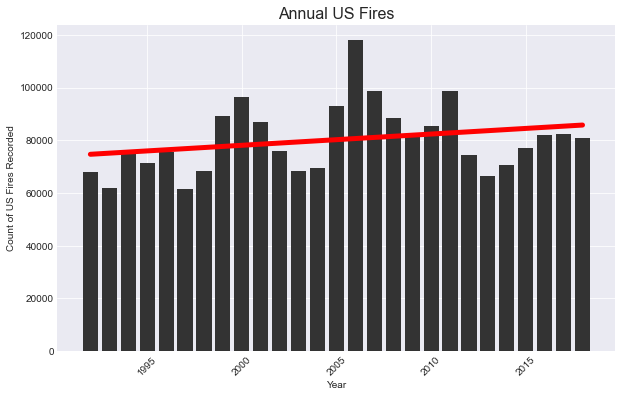

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(x, y, color=(.2,.2,.2))
ls = np.polyfit(x, y, deg=1)
ax.plot(x, x*ls[0] + ls[1], color='red', linewidth=5);

plt.xticks(rotation=45)
plt.xlabel('Year');
plt.ylabel('Count of US Fires Recorded');
plt.title('Annual US Fires', size=16);